## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
import numpy as np
import os
import math
import collections
from faraday_common import Observation

C:\Users\Jackson\physics_387\faraday\faraday_common.py:180: RuntimeWarning: invalid value encountered in arccos
  phi = np.rad2deg(np.arccos(np.sqrt((m1-V)/m2)))+m3


## Load Data

In [2]:
data_file = 'data/faraday_data.xlsx'

In [3]:
full_df = pd.read_excel(data_file)
full_df

,Magnetic Field voltage (V),Magnetic Field Current (Amps),Magnetic Field (mT),Filter,Sample (cm),Min transmission angle,Unnamed: 6,Angle 1,Value 1,Angle 2,...,Value 6,Angle 7,Value 7,Angle 8,Value 8,Angle 9,Value 9,Unnamed: 25,Zero Field Angle,Intensity
0,0,0.00,1.73,Red,1.036,334,NaN,294,0.0315,304,...,0.00250,354,0.00760,364,0.0170,374,0.0300,NaN,335.274926,0.00101
1,0,0.00,1.73,Red,0.956,332,NaN,292,0.0426,302,...,0.00275,352,0.00672,362,0.0137,372,0.0214,NaN,338.287840,0.00269
2,0,0.00,1.73,Red,1.272,339,NaN,299,0.0223,309,...,0.00447,359,0.01080,369,0.0186,379,0.0275,NaN,335.957915,0.00211
3,0,0.00,1.73,Blue,1.272,332,NaN,292,0.0526,302,...,0.00696,352,0.01580,362,0.0300,372,0.0457,NaN,334.224460,0.00517
4,0,0.00,1.73,Blue,0.956,340,NaN,300,0.0548,310,...,0.01620,360,0.03240,370,0.0508,380,0.0646,NaN,336.576890,0.00729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,-30,-1.22,-230.54,Blue,1.272,346,NaN,306,0.0210,316,...,0.00360,366,0.00878,376,0.0157,386,0.0234,NaN,334.224460,0.01000
59,-30,-1.22,-230.54,Blue,1.036,313,NaN,273,0.0532,283,...,0.00499,333,0.01600,343,0.0310,353,0.0468,NaN,336.148007,0.01630
60,-30,-1.22,-230.54,Red,0.956,341,NaN,301,0.0230,311,...,0.00615,361,0.01290,371,0.0222,381,0.0313,NaN,338.287840,0.00293
61,-30,-1.22,-230.54,Red,1.272,340,NaN,300,0.0249,310,...,0.00202,360,0.00608,370,0.0118,380,0.0194,NaN,335.957915,0.00234


In [4]:
observation_arr = []
for i, row in full_df.iterrows():
    mag_field_volt, mag_field_curr, mag_field, filter, sample, min_trans_eye = row[0:6].values
    p3_intensity = row[-1]
    angles = [row[f"Angle {j}"] for j in range(1, 10)]
    intensities = [row[f"Value {j}"] for j in range(1, 10)]
    observation = Observation(mag_field, 
                              filter, 
                              sample, 
                              min_trans_eye, 
                              angles, 
                              intensities,
                              p3_intensity)
    observation_arr.append(observation)

C:\Users\Jackson\AppData\Local\Temp\ipykernel_6020\3574587360.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p3_intensity = row[-1]


## Method 1: Minimum eye transmissions versus Field

In [5]:
from faraday_common import findRanges, minEyeTransmission

In [6]:
minEyeTransmissionVersusMagneticField = minEyeTransmission(full_df)
anglesVFieldDict = minEyeTransmissionVersusMagneticField.transmissionAnglesVersusBField
print(anglesVFieldDict)

{'1.036_Red': [array([334, 339, 340, 347, 332, 330, 328], dtype=int64), array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157.94, -230.54])], '1.036_Blue': [array([337, 335, 332, 358, 334, 320, 313], dtype=int64), array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157.94, -230.54])], '1.036_Yellow': [array([335, 340, 346, 350, 331, 326, 320], dtype=int64), array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157.94, -230.54])], '0.956_Red': [array([332, 333, 331, 336, 331, 336, 341], dtype=int64), array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157.94, -230.54])], '0.956_Blue': [array([340, 336, 335, 337, 337, 337, 336], dtype=int64), array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157.94, -230.54])], '0.956_Yellow': [array([334, 335, 336, 338, 338, 339, 337], dtype=int64), array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157.94, -230.54])], '1.272_Red': [array([339, 333, 337, 333, 338, 339, 340], dtype=int64), array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157

In [7]:
slopeDict = {  #We'll store the B vs phi slopes here which we can convert at the end
    "Method1": [],
    "Method2": [],
    "Method3": []
}

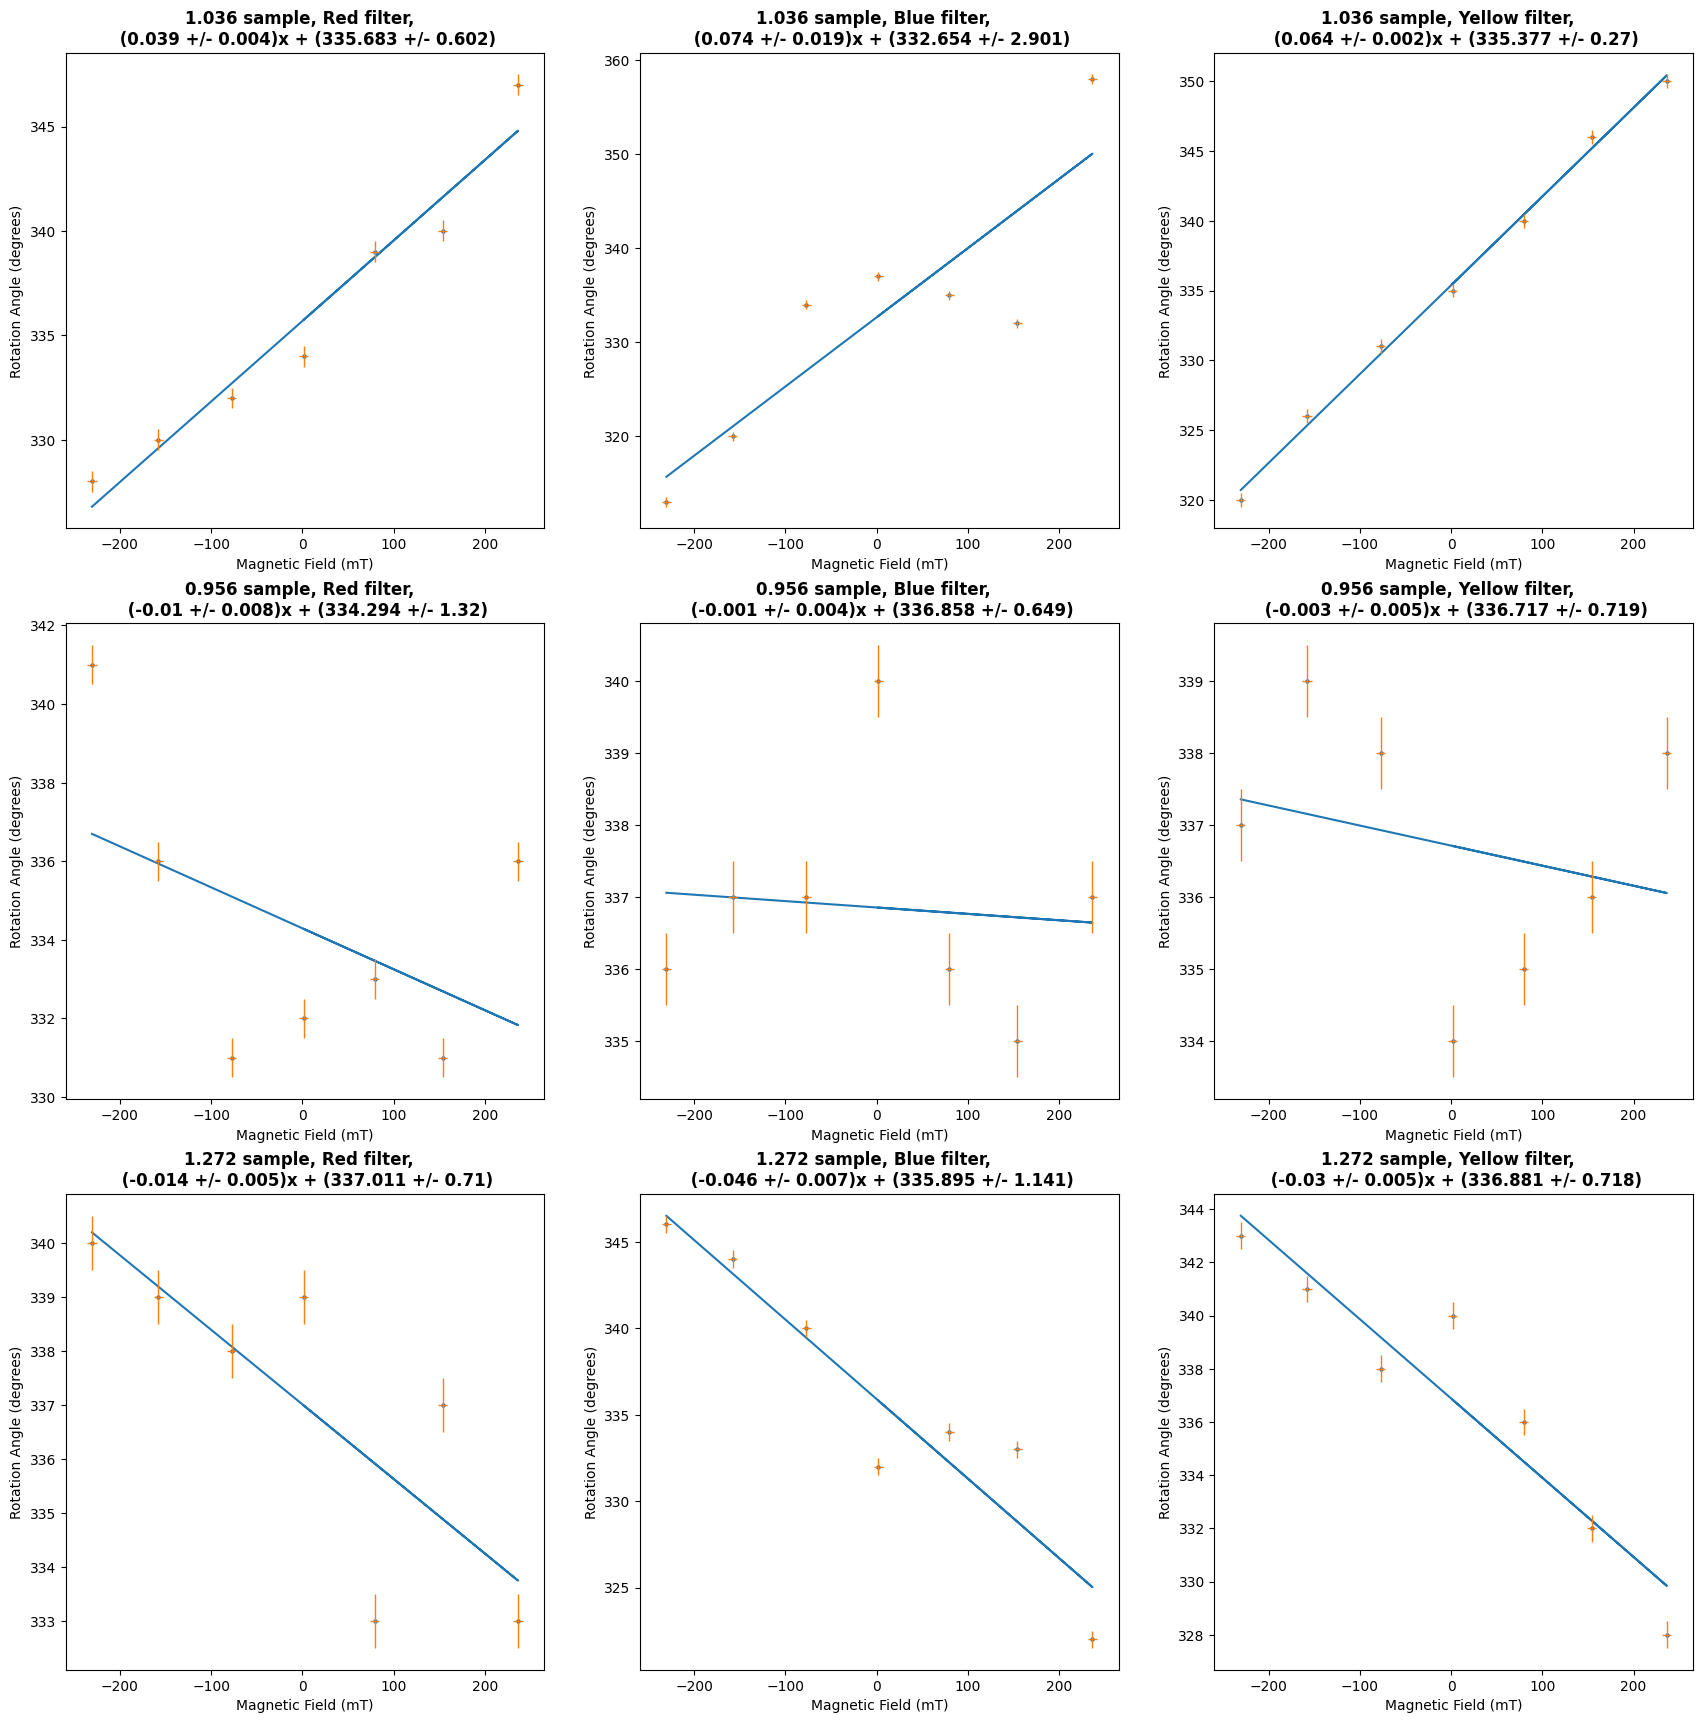

In [8]:
n = len(anglesVFieldDict)
berror = 5
aerror = 0.5
FIGSIZE = 21
fig, ax = plt.subplots(3,3, figsize = (FIGSIZE, FIGSIZE))
i = 0


def line(x, A, B):
    return A*x + B



for key, values in anglesVFieldDict.items():
    x=(int)(i/3)
    y = i%3


    angle_vals = values[0]
    B_vals = values[1]


    Berror = np.ones(len(B_vals))*berror
    angleError = np.ones(len(angle_vals))*aerror

    popt, pcov = curve_fit(line,   B_vals, angle_vals)
    perr = np.sqrt(np.diag(pcov))

    ax[x][y].plot(B_vals, line(B_vals, popt[0], popt[1]))
    ax[x][y].scatter(B_vals, angle_vals, s=5)
    ax[x][y].errorbar(B_vals, angle_vals, xerr = Berror, yerr = angleError, linewidth = 0, elinewidth = 1)
    
    ax[x][y].set_xlabel("Magnetic Field (mT)")
    ax[x][y].set_ylabel("Rotation Angle (degrees)")
    ax[x][y].set_title(f"{key[0:5]} sample, {key[6:]} filter,  \n ({np.around(popt[0], 3)} +/- {np.around(perr[0], 3)})x + ({np.around(popt[1], 3)} +/- {np.around(perr[1], 3)})", fontweight = 'bold')
    
    
    
    slopeDict["Method1"].append({
        'm' : popt[0],
        'merr' : perr[0],
        'd' : (float)(key[0:5]),
        'filter' : key[6:]
    })

    i+=1
    

In [9]:
slopeDict

{'Method1': [{'m': 0.03856141665661996,
   'merr': 0.003864608050741056,
   'd': 1.036,
   'filter': 'Red'},
  {'m': 0.07360823784860192,
   'merr': 0.018616371897610923,
   'd': 1.036,
   'filter': 'Blue'},
  {'m': 0.06367689373912769,
   'merr': 0.0017308960731094334,
   'd': 1.036,
   'filter': 'Yellow'},
  {'m': -0.01041980858610613,
   'merr': 0.008470516715953067,
   'd': 0.956,
   'filter': 'Red'},
  {'m': -0.000886674177729363,
   'merr': 0.004162371828923249,
   'd': 0.956,
   'filter': 'Blue'},
  {'m': -0.0027843754611720506,
   'merr': 0.0046163972492454615,
   'd': 0.956,
   'filter': 'Yellow'},
  {'m': -0.013797483431682508,
   'merr': 0.004556452782332746,
   'd': 1.272,
   'filter': 'Red'},
  {'m': -0.04597922077900982,
   'merr': 0.007319880396244032,
   'd': 1.272,
   'filter': 'Blue'},
  {'m': -0.02978819992398529,
   'merr': 0.004607397762687241,
   'd': 1.272,
   'filter': 'Yellow'}],
 'Method2': [],
 'Method3': []}

## Method 2: Malus curve fit at each B field

In [10]:
from faraday_common import SampleAndFilter, MalusFit
sample_and_filter_dict = collections.defaultdict(dict)

##Initialize with 0 field sample/filters
for observation in observation_arr[:9]:
    sample_and_filter_dict[observation.filter][observation.sample] = SampleAndFilter(observation.filter, observation.sample)

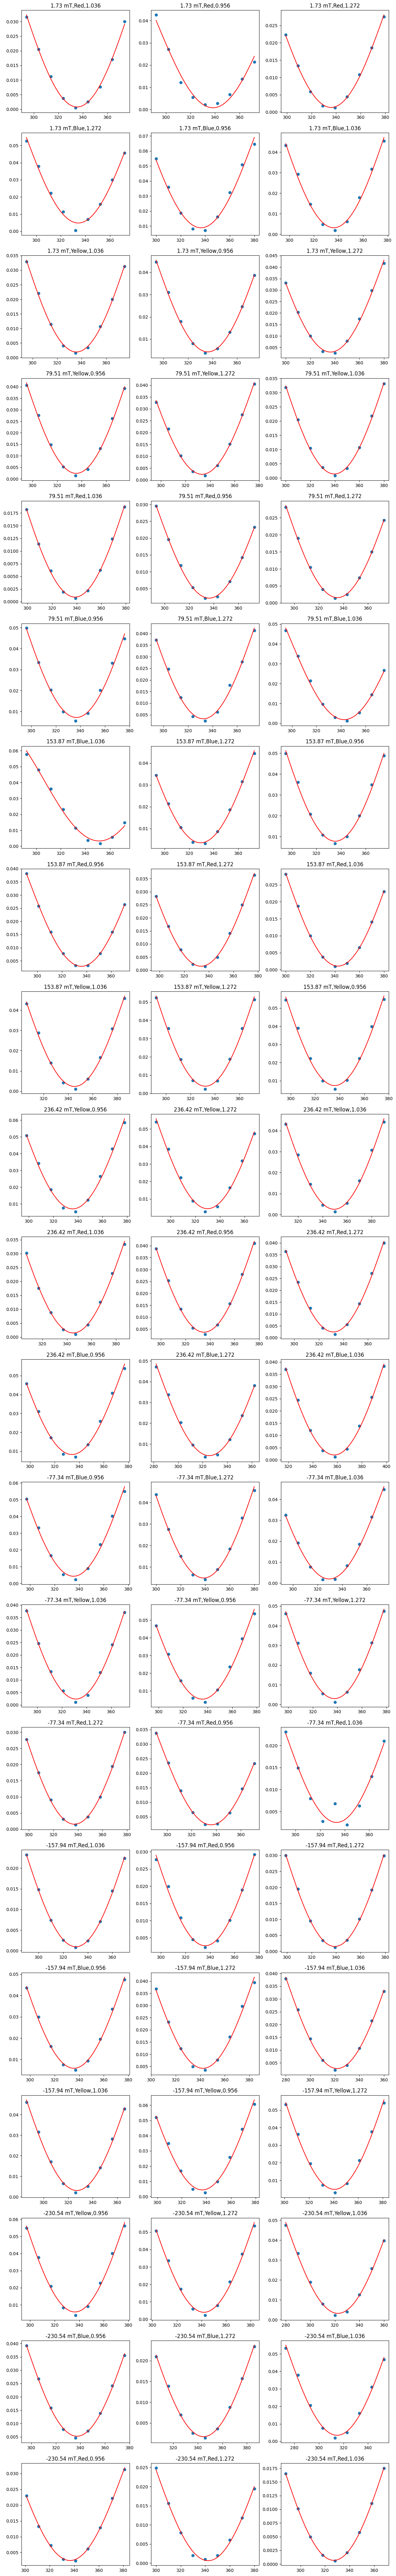

In [11]:
## Fit the 63 field/sample/filter combos
n_figures = 63
fig, axes = plt.subplots(n_figures // 3, 3, figsize = (15, 5 * n_figures // 3))

for i, ax in enumerate(axes.flatten()):
    observation = observation_arr[i]
    mf = MalusFit(observation)
    mf.plot_fit(ax)
    sample_and_filter = sample_and_filter_dict[observation.filter][observation.sample]
    sample_and_filter.mag_field_arr.append(observation.mag_field)
    sample_and_filter.angle_arr.append(mf.get_min_angle())

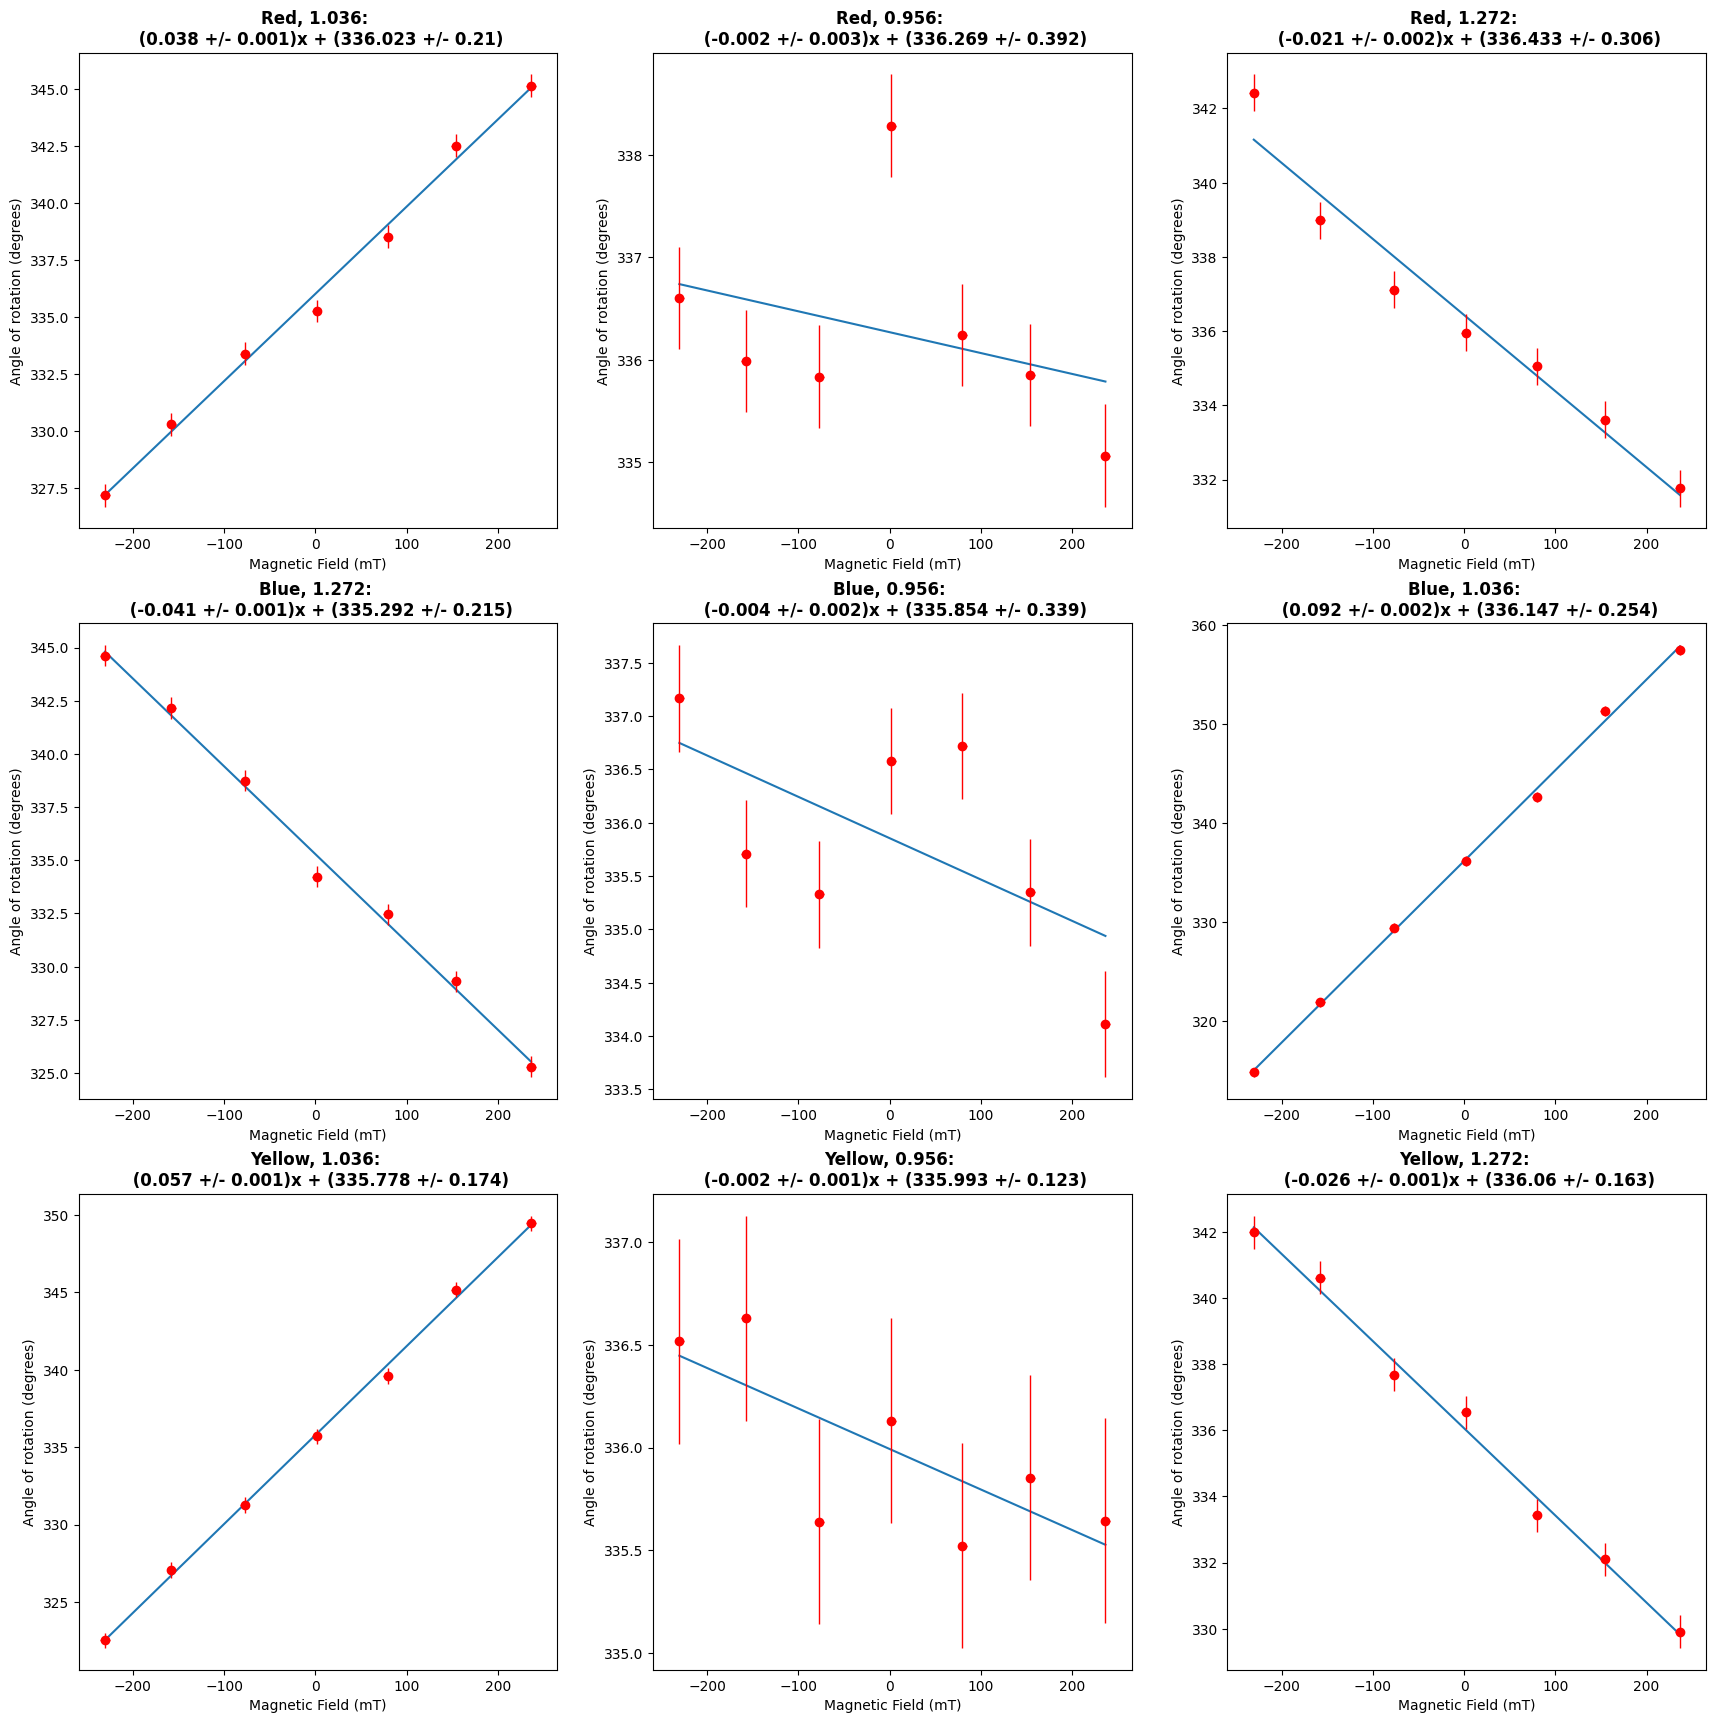

In [12]:
fig, axes = plt.subplots(3, 3, figsize = (21, 21))

for i, filter in enumerate(sample_and_filter_dict.keys()):
    for j, sample in enumerate(sample_and_filter_dict[filter].keys()):
        sample_and_filter = sample_and_filter_dict[filter][sample]
        sample_and_filter.fit()
        sample_and_filter.plot_fit(axes[i, j])
        
        slopeDict["Method2"].append({
            'm' : sample_and_filter.a,
            'merr' : sample_and_filter.aerr,
            'd' : (float)(sample),
            'filter' : filter
        })

In [13]:
slopeDict

{'Method1': [{'m': 0.03856141665661996,
   'merr': 0.003864608050741056,
   'd': 1.036,
   'filter': 'Red'},
  {'m': 0.07360823784860192,
   'merr': 0.018616371897610923,
   'd': 1.036,
   'filter': 'Blue'},
  {'m': 0.06367689373912769,
   'merr': 0.0017308960731094334,
   'd': 1.036,
   'filter': 'Yellow'},
  {'m': -0.01041980858610613,
   'merr': 0.008470516715953067,
   'd': 0.956,
   'filter': 'Red'},
  {'m': -0.000886674177729363,
   'merr': 0.004162371828923249,
   'd': 0.956,
   'filter': 'Blue'},
  {'m': -0.0027843754611720506,
   'merr': 0.0046163972492454615,
   'd': 0.956,
   'filter': 'Yellow'},
  {'m': -0.013797483431682508,
   'merr': 0.004556452782332746,
   'd': 1.272,
   'filter': 'Red'},
  {'m': -0.04597922077900982,
   'merr': 0.007319880396244032,
   'd': 1.272,
   'filter': 'Blue'},
  {'m': -0.02978819992398529,
   'merr': 0.004607397762687241,
   'd': 1.272,
   'filter': 'Yellow'}],
 'Method2': [{'m': 0.03823869491868239,
   'merr': 0.0013465659278067644,
   'd': 

## Method 3: Zero Field Malus

In [14]:
from faraday_common import zeroFieldMalus

In [20]:
##Create dictionary indexed by sample and filter, and containing zero field malus fit
sample_filter_zfm = collections.defaultdict(dict)
for observation in observation_arr[:9]:
    mf = MalusFit(observation)
    sample_filter_zfm[observation.filter][observation.sample] = mf

C:\Users\Jackson\physics_387\faraday\faraday_common.py:180: RuntimeWarning: invalid value encountered in arccos
  phi = np.rad2deg(np.arccos(np.sqrt((m1-V)/m2)))+m3


In [21]:
##Initialize with 0 field sample/filters
sample_and_filter_dict = collections.defaultdict(dict)
for observation in observation_arr[:9]:
    sample_and_filter_dict[observation.filter][observation.sample] = SampleAndFilter(observation.filter, observation.sample)

In [22]:
for observation in observation_arr:
    mf = sample_filter_zfm[observation.filter][observation.sample]
    angle = mf.angle_from_voltage(observation.p3_intensity, negative = (observation.mag_field < 0))
    saf = sample_and_filter_dict[observation.filter][observation.sample]
    saf.angle_arr.append(angle)
    saf.mag_field_arr.append(observation.mag_field)

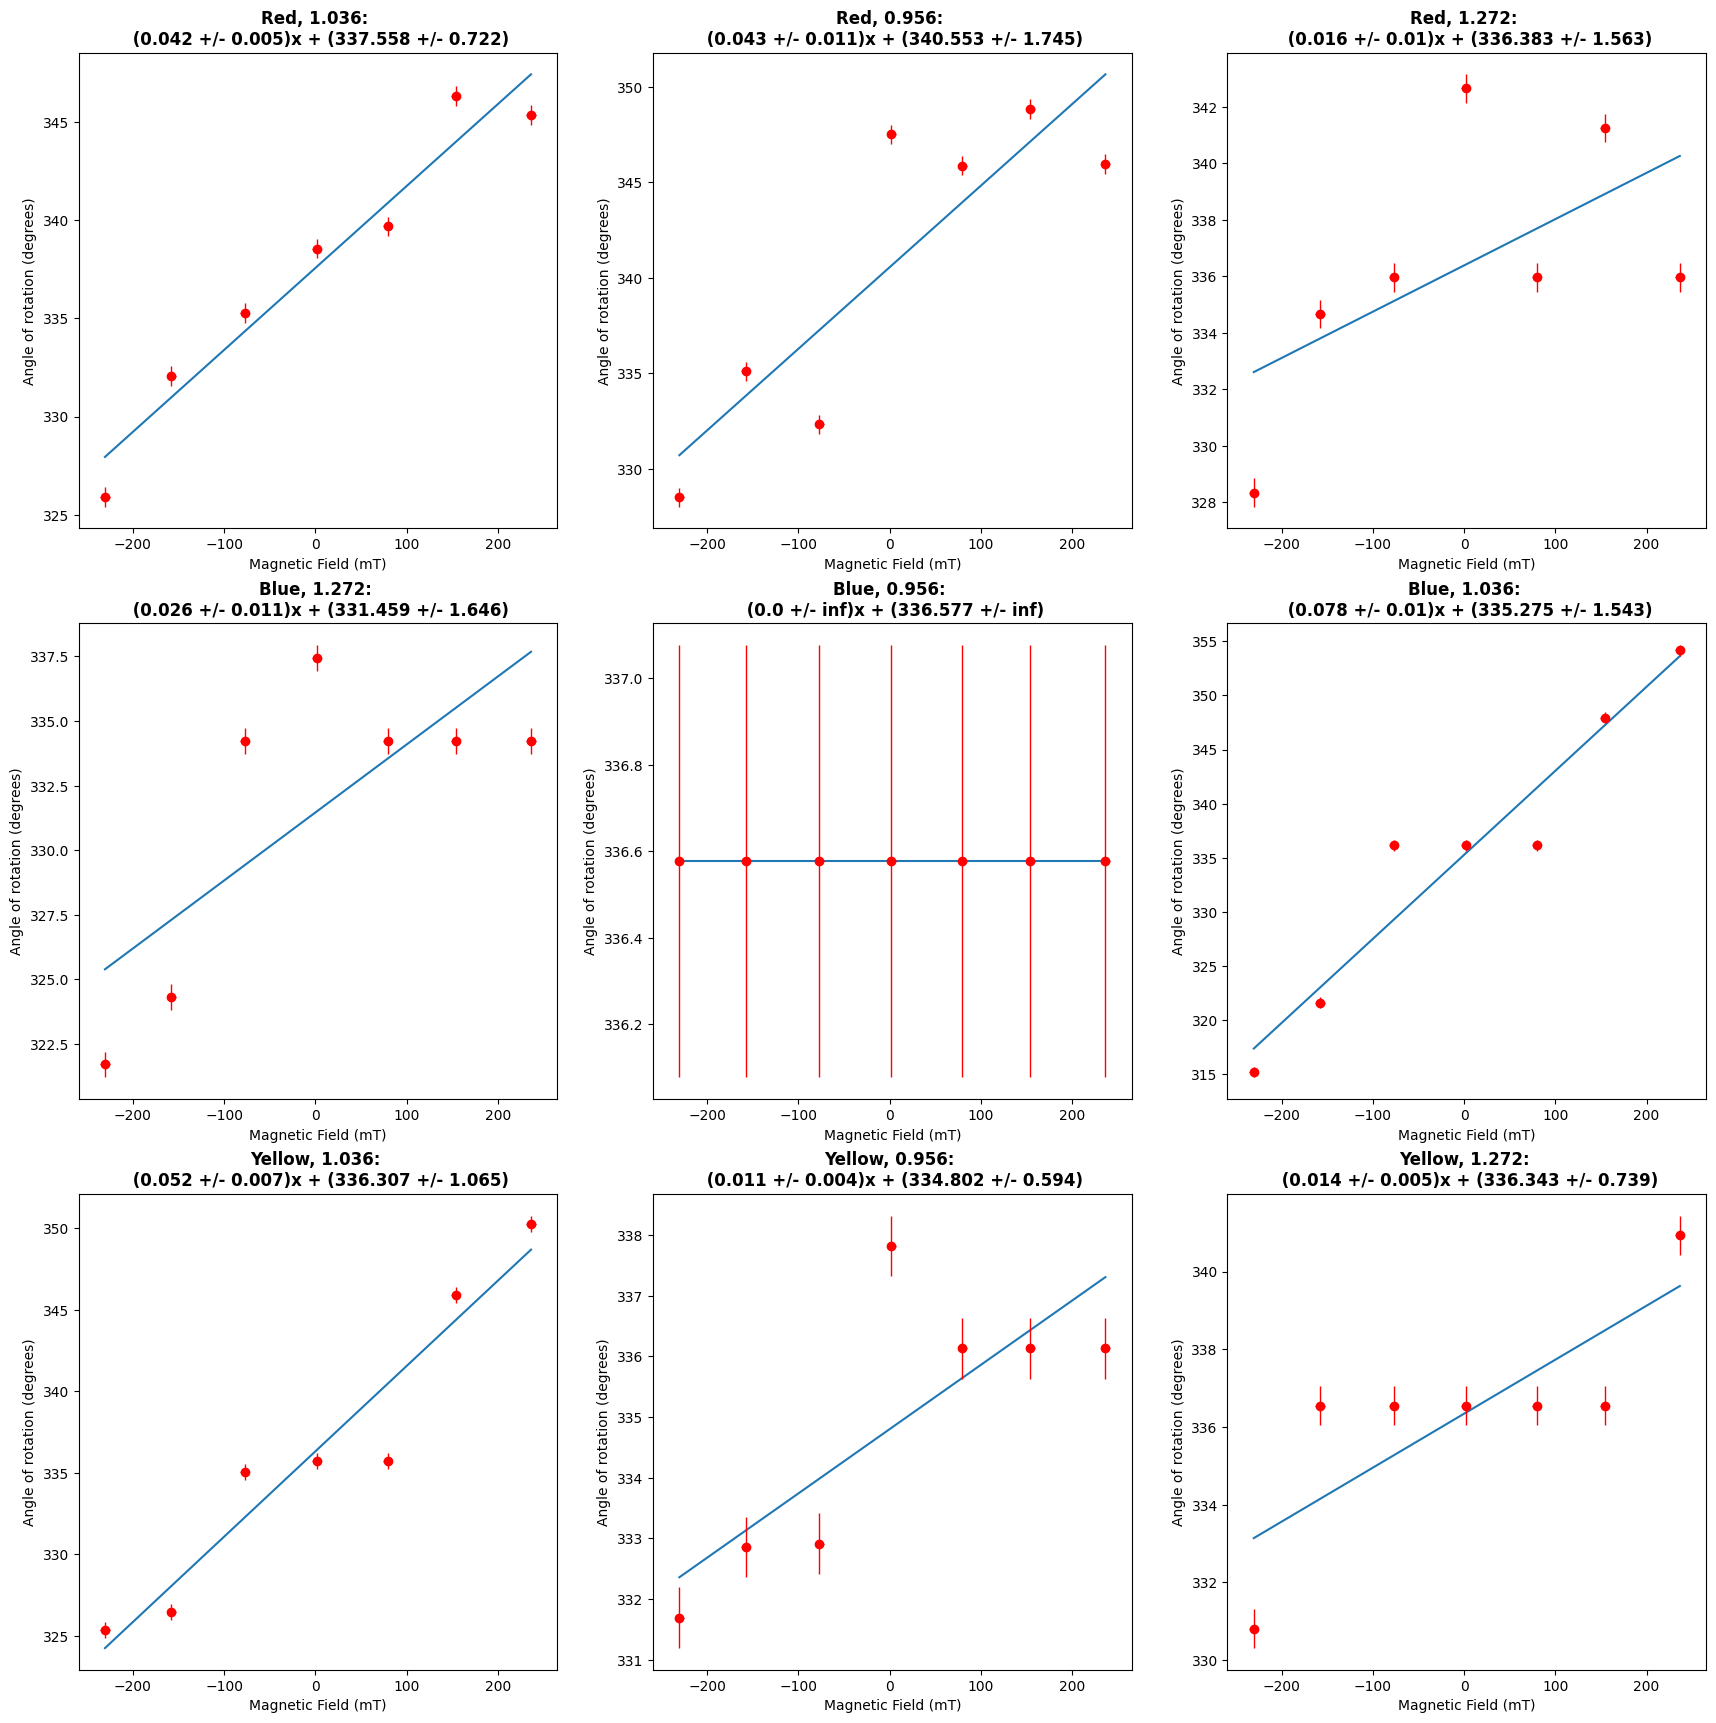

In [25]:
fig, axes = plt.subplots(3, 3, figsize = (21, 21))

for i, filter in enumerate(sample_and_filter_dict.keys()):
    for j, sample in enumerate(sample_and_filter_dict[filter].keys()):
        sample_and_filter = sample_and_filter_dict[filter][sample]
        sample_and_filter.fit()
        sample_and_filter.plot_fit(axes[i, j])
        slopeDict["Method3"].append({
            'm' : sample_and_filter.a,
            'merr' : sample_and_filter.aerr,
            'd' : (float)(sample),
            'filter' : filter
        })

# Analysis #

## Verdet Constants ##

### Method 1 ###

In [26]:
method1 = slopeDict['Method1']
conversion_constant = 100 * 1000 * (np.pi)/(180)
print(method1)
for element in method1:
    m = element['m']
    merr = element['merr']
    d = element['d']
    filter = element['filter']

    print(f"The Verdet constant is: {(m/d)*conversion_constant} +/- {(merr/d)*conversion_constant}. for the {filter} filter and {d} sample")

[{'m': 0.03856141665661996, 'merr': 0.003864608050741056, 'd': 1.036, 'filter': 'Red'}, {'m': 0.07360823784860192, 'merr': 0.018616371897610923, 'd': 1.036, 'filter': 'Blue'}, {'m': 0.06367689373912769, 'merr': 0.0017308960731094334, 'd': 1.036, 'filter': 'Yellow'}, {'m': -0.01041980858610613, 'merr': 0.008470516715953067, 'd': 0.956, 'filter': 'Red'}, {'m': -0.000886674177729363, 'merr': 0.004162371828923249, 'd': 0.956, 'filter': 'Blue'}, {'m': -0.0027843754611720506, 'merr': 0.0046163972492454615, 'd': 0.956, 'filter': 'Yellow'}, {'m': -0.013797483431682508, 'merr': 0.004556452782332746, 'd': 1.272, 'filter': 'Red'}, {'m': -0.04597922077900982, 'merr': 0.007319880396244032, 'd': 1.272, 'filter': 'Blue'}, {'m': -0.02978819992398529, 'merr': 0.004607397762687241, 'd': 1.272, 'filter': 'Yellow'}]
The Verdet constant is: 64.96367614781872 +/- 6.510630770705744. for the Red filter and 1.036 sample
The Verdet constant is: 124.00638098930605 +/- 31.36264328079684. for the Blue filter and 1

### Method 2 ###

In [36]:
method2 = slopeDict['Method2']
conversion_constant = 100 * 1000 * (np.pi)/(180)
print(method2)
v_const_dict = collections.defaultdict(dict)
for element in method2:
    m = element['m']
    merr = element['merr']
    d = element['d']
    filter = element['filter']

    v_const = (m/d)*conversion_constant
    v_err = (merr/d)*conversion_constant
    v_const_dict[d][filter] = (v_const, v_err)

    print(f"The Verdet constant is: {v_const} +/- {v_err}. for the {filter} filter and {d} sample")

[{'m': 0.03823869491868239, 'merr': 0.0013465659278067644, 'd': 1.036, 'filter': 'Red'}, {'m': -0.002038222227525477, 'merr': 0.0025148117910970464, 'd': 0.956, 'filter': 'Red'}, {'m': -0.02050387472207781, 'merr': 0.0019621564126911678, 'd': 1.272, 'filter': 'Red'}, {'m': -0.04126506155384321, 'merr': 0.001377421479293639, 'd': 1.272, 'filter': 'Blue'}, {'m': -0.0038762151510286008, 'merr': 0.002177084330666903, 'd': 0.956, 'filter': 'Blue'}, {'m': 0.09176628681780406, 'merr': 0.0016275270322186194, 'd': 1.036, 'filter': 'Blue'}, {'m': 0.05744287563558993, 'merr': 0.0011196727705382547, 'd': 1.036, 'filter': 'Yellow'}, {'m': -0.001973681168936814, 'merr': 0.0007874580494099145, 'd': 0.956, 'filter': 'Yellow'}, {'m': -0.02637129963032423, 'merr': 0.0010479906164708255, 'd': 1.272, 'filter': 'Yellow'}]
The Verdet constant is: 64.41999304986804 +/- 2.2685336906757048. for the Red filter and 1.036 sample
The Verdet constant is: -3.7210971503820676 +/- 4.591186801529213. for the Red filter

### Method 3

In [35]:
method2 = slopeDict['Method3']
conversion_constant = 100 * 1000 * (np.pi)/(180)
print(method2)
for element in method2:
    m = element['m']
    merr = element['merr']
    d = element['d']
    filter = element['filter']

    v_const = (m/d)*conversion_constant
    v_err = (merr/d)*conversion_constant

    print(f"The Verdet constant is: {v_const} +/- {v_err}. for the {filter} filter and {d} sample")

[{'m': 0.04168918279622827, 'merr': 0.004635201735045564, 'd': 1.036, 'filter': 'Red'}, {'m': 0.04270295309522422, 'merr': 0.011200183085795002, 'd': 0.956, 'filter': 'Red'}, {'m': 0.01638834351889888, 'merr': 0.010033479829111378, 'd': 1.272, 'filter': 'Red'}, {'m': 0.026307327491291943, 'merr': 0.010561579677119768, 'd': 1.272, 'filter': 'Blue'}, {'m': 1.2545586791645746e-10, 'merr': inf, 'd': 0.956, 'filter': 'Blue'}, {'m': 0.07762565287446069, 'merr': 0.009901069122801302, 'd': 1.036, 'filter': 'Blue'}, {'m': 0.05235787706040557, 'merr': 0.006835481688031423, 'd': 1.036, 'filter': 'Yellow'}, {'m': 0.010588839445721412, 'merr': 0.0038116142349944827, 'd': 0.956, 'filter': 'Yellow'}, {'m': 0.013887752181427088, 'merr': 0.004740287792583275, 'd': 1.272, 'filter': 'Yellow'}]
The Verdet constant is: 70.23296353860613 +/- 7.808835113001825. for the Red filter and 1.036 sample
The Verdet constant is: 77.96099705401319 +/- 20.447706241977123. for the Red filter and 0.956 sample
The Verdet 

## Flint Cauchy Analysis

In [37]:
from faraday_common import CauchyFit
nm = 1e-9
c = 3 * 10 ** 8
charge2mass = - 1.758820 * 10 ** 11

In [38]:
flint_data_file = 'data/flint_dispersion.xlsx'

In [39]:
flint_df = pd.read_excel(flint_data_file)
flint_df

,Wavelength (nm),Index
0,1014.0,1.9117
1,852.1,1.9206
2,706.5,1.9342
3,656.3,1.9412
4,643.8,1.9433
5,632.8,1.9452
6,587.6,1.9545
7,546.1,1.9654
8,486.1,1.9880
9,480.0,1.9909


In [40]:
wavelength_arr = flint_df["Wavelength (nm)"].to_numpy() * nm
index_arr = flint_df["Index"].to_numpy()
cf = CauchyFit(wavelength_arr, index_arr)

C:\Users\Jackson\physics_387\faraday\faraday_common.py:180: RuntimeWarning: invalid value encountered in arccos
  phi = np.rad2deg(np.arccos(np.sqrt((m1-V)/m2)))+m3


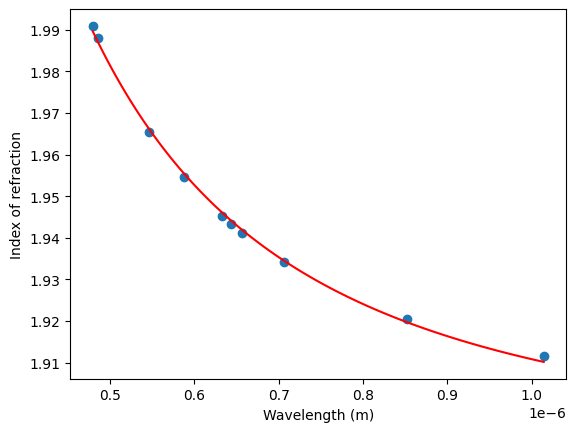

In [43]:
fig, ax = plt.subplots()
cf.plot_fit(ax)

For the flint sample, we find dn/dl from both the dispersion relation and verdet constant for all three wavelengths:

In [55]:
wavelength_dict = {'Blue': 449.5 * nm, 'Yellow': 549 * nm, 'Red': 650 * nm}
x_arr = []
y_arr = []
y_err = []
for color in v_const_dict[1.272].keys():
    wavelength = wavelength_dict[color]
    v_const, v_err = v_const_dict[1.272][color]
    dispersion_derivative = cf.get_dispersion_derivative(wavelength)
    v_derivative = -2 * v_const * c / (wavelength * charge2mass)
    v_derivative_err = -2 * v_err * c / (wavelength * charge2mass)

    x_arr.append(dispersion_derivative)
    y_arr.append(2 * v_const * c / wavelength)
    y_err.append(2 * v_err * c / wavelength)
    
    print(f"{color} dn/dl: From Cauchy fitting: {dispersion_derivative} "
          f"From measured Verdet Constant: {v_derivative} +/- {v_derivative_err}")

Red dn/dl: From Cauchy fitting: -171695.71115708977 From measured Verdet Constant: -147653.14241340582 +/- 14129.941982551634
Blue dn/dl: From Cauchy fitting: -519171.0037155224 From measured Verdet Constant: -429707.4788272717 +/- 14343.57029559975
Yellow dn/dl: From Cauchy fitting: -284959.0691767912 From measured Verdet Constant: -224842.96307882687 +/- 8935.218164794322


Finding e/m ratio:

Text(0, 0.5, '2Vc/lambda')

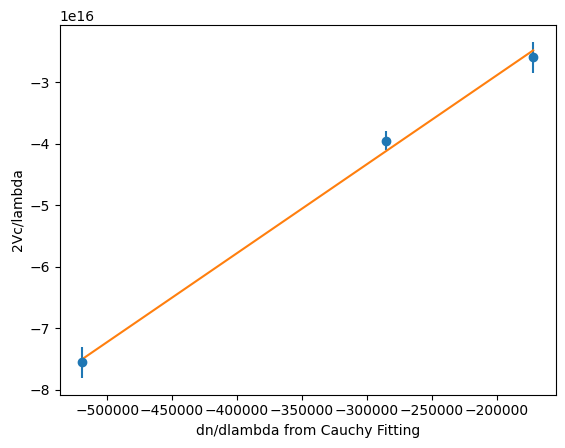

In [72]:
def line(x, A, B):
        return A*x + B

params, cov = curve_fit(line, 
                    x_arr, 
                    y_arr, 
                    p0 = [-charge2mass, charge2mass]) 

plt.errorbar(x_arr, y_arr, yerr = y_err, fmt = 'o')
x_fit_arr = np.linspace(np.min(x_arr), np.max(x_arr), 100)
y_fit_arr = line(x_fit_arr, params[0], params[1])
plt.plot(x_fit_arr, y_fit_arr)

plt.xlabel("dn/dlambda from Cauchy Fitting")
plt.ylabel("2Vc/lambda")

In [74]:
c2m_measured = params[0]
c2m_err = np.sqrt(cov[0, 0])
print(f"Experimental charge to mass: {c2m_measured} +/- {c2m_err}") 

Experimental charge to mass: 144432918258.3144 +/- 8285801133.339298
